# Lab 5 (a): Stable Diffusion + Dynamic Guidance Scheduler


Stable Diffusion is a powerful text-to-image model. There are various websites and tools to make using it as easy as possible. It is also [integrated into the Huggingface diffusers library](https://huggingface.co/blog/stable_diffusion) where generating images can be as simple as:
```python
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", variant="fp16", torch_dtype=torch.float16, use_auth_token=True).to("cuda")
image = pipe("An astronaught scuba diving").images[0]

```

In this notebook we're going to dig into the code behind these easy-to-use interfaces, to see what is going on under the hood. We'll begin by re-creating the functionality above as a scary chunk of code, and then one by one we'll inspect the different components and figure out what they do. By the end of this notebook that same sampling loop should feel like something you can tweak and modify as you like.

## Setup & Imports

You'll need to log into huggingface and accept the terms of the licence for this model - see the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) for details. And when you first run this notebook you need to uncomment the following two cells to install the requirements and log in to huggingface with an access token.

In [2]:
pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.9/314.9 kB 18.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.3/566.3 kB 36.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)


In [3]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel, DDIMScheduler
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Loading the models

This code (and that in the next section) comes from the [Huggingface example notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

This will download and set up the relevant models and components we'll be using. Let's just run this for now and move on to the next section to check that it all works before diving deeper.

If you've loaded a pipeline, you can also access these components using `pipe.unet`, `pipe.vae` and so on.

In this notebook we aren't doing any memory-saving tricks - if you find yourself running out of GPU RAM, look at the pipeline code for inspiration with things like attention slicing, switching to half precision (fp16), keeping the VAE on the CPU and other modifications.

## The Variational Autoencoder (VAE)

The VAE can 'encode' an image into some sort of latent representation, and decode this back into an image. I've wrapped the code for this into a couple of functions here so we can see what this looks like in action:

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae = vae.to(torch_device)


def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [5]:
# Download a demo Image
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58602  100 58602    0     0   203k      0 --:--:-- --:--:-- --:--:--  203k


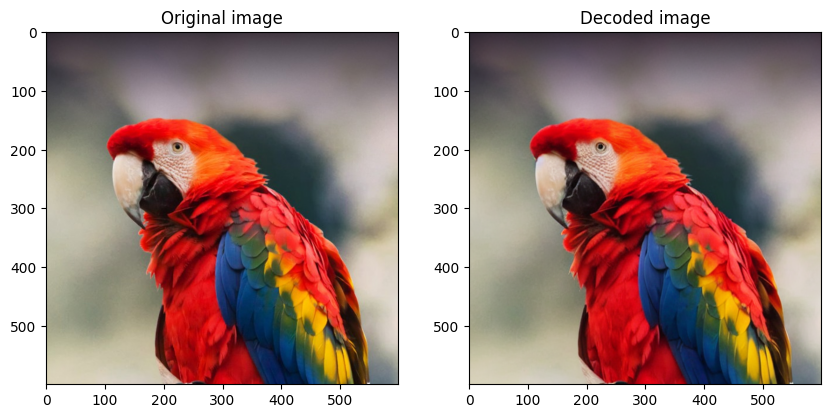

MSE: 19.929517592592592
PSNR: 35.135835744308785


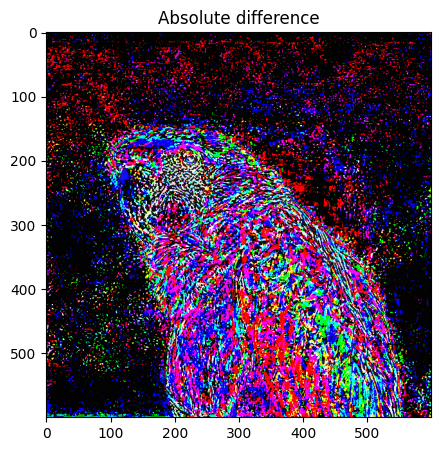

In [6]:
###############################################################################
# Complete the Code:
# Use VAE to encode and decode an image, then show the difference before and after re-decoding
# show MSE and PSNR, and abs diffed images:
# you can also test with your own images
##############################################################################

encoded_image = pil_to_latent(Image.open('macaw.jpg'))
decoded_image = latents_to_pil(encoded_image)[0]

# show before vs after
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Image.open('macaw.jpg'))
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(decoded_image)
plt.title('Decoded image')
plt.show()

# and mse/psnr
mse = numpy.mean((numpy.array(Image.open('macaw.jpg')) - numpy.array(decoded_image)) ** 2)
psnr = 10 * numpy.log10(255 ** 2 / mse)
print('MSE:', mse)
print('PSNR:', psnr)

#absolute diffed images
plt.figure(figsize=(10, 5))
plt.imshow(numpy.abs(numpy.array(Image.open('macaw.jpg')) - numpy.array(decoded_image)))
plt.title('Absolute difference')
plt.show()

##############################################################################



# Task 1:
Fill the code of computing MSE and PSNR, as well as the code doing VAE and psnr.
Show the difference of image between ground truth and re-decoded images, report their metrics in PNSR (dB).
Extra: visualize each channel of VAE space matrice.



# Question 1:
Explain why we use VAE to encode image for diffusion, what could be the pros and cons.

# Answer:


VAE is used in stable diffusion to create a latent diffusion model  which operates in a compressed latent space rather than pixel space.

**Pros:**
 - **Computational Efficiency**: The VAE compresses large images to 64×64 latent representations and then dramatically reduces memory and computation requirements during diffusion
 - **Semantic Compression**: The VAE learns to encode perceptually important features while discarding imperceptible details, which makes the diffusion process focus on the meaningful image structure and not at pixel level noise
 - **Fast Training & Sampling**: Working in lower-dimensional latent space means that less denoising steps are needed and each step gets faster to compute
 - **Better Gradient Flow**: The continuous latent space provides smoother gradienst compared to discrete pixel space

**Cons:**
 - **Quality Loss**: The VAE reconstruction creates a loss of quality, by introducing compression artifacts for example, that limit the maximum quality of generated images. Also some tiny details can be lost
 - **Fixed Bottleneck**: The VAE is pre-trained and frozen, so its limitations cannot be overcome by training the diffusion model longer
 - **Two-Stage Training**: training the VAE firsta nd then the diffusion model makes the pipeline more complex


# The Scheduler

The scheduler is in charge of noising images, in Huggingface, off-the-shelf scheduler are availible for us to explore:

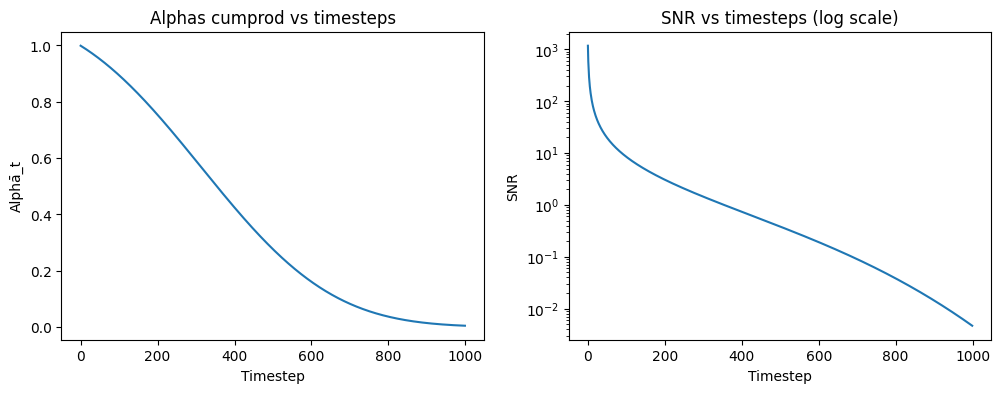

In [8]:

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
total_sampling_steps = 30
scheduler.set_timesteps(total_sampling_steps)
###############################################################################
# Complete the Code:
# plot scheduler's timesteps vs. alphas
# and plot also the SNR curve : check snr definition in https://arxiv.org/pdf/2107.00630.pdf
# check the manual of the scheduler we use LMSDiscreteScheduler in huggingface: https://huggingface.co/docs/diffusers/api/schedulers/lms_discrete
##############################################################################

import numpy as np

# Alphas cumul prod / snr
alphas_cumprod = scheduler.alphas_cumprod.cpu().numpy()
timesteps = np.arange(len(alphas_cumprod))

snr = alphas_cumprod / (1 - alphas_cumprod)

# figures
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(timesteps, alphas_cumprod)
plt.title("Alphas cumprod vs timesteps")
plt.xlabel("Timestep")
plt.ylabel("Alphā_t")

plt.subplot(1, 2, 2)
plt.plot(timesteps, snr)
plt.yscale("log")
plt.title("SNR vs timesteps (log scale)")
plt.xlabel("Timestep")
plt.ylabel("SNR")

plt.show()


##############################################################################


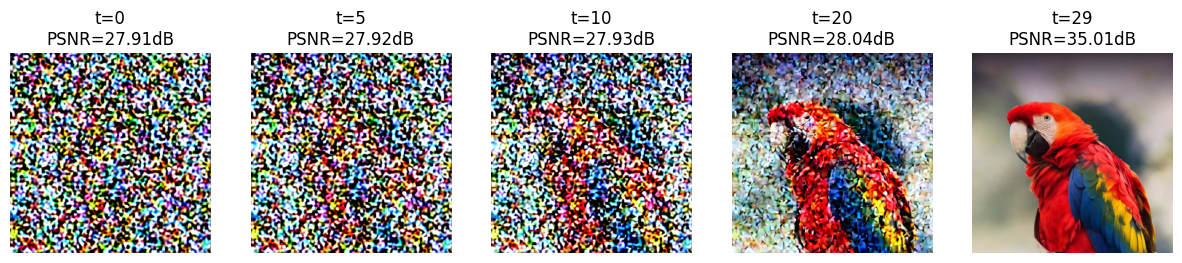

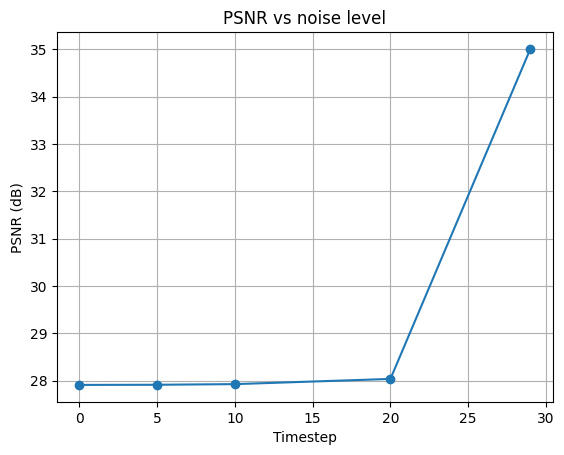

In [12]:
encoded = encoded_image #just to match the code from the lab and avoid bugs
noise = torch.randn_like(encoded) # Random noise
scheduler.set_timesteps(30) # we do 30 steps, max timestep is 29
###############################################################################
# Complete the Code:
# Use the noise scheduler to noise your previous found latent with certain steps
# and show their evolution with different level of noises
# hint use the function: scheduler.add_noise / scheduler.set_timesteps / scheduler.timesteps
##############################################################################

scheduler.set_timesteps(30)

timesteps = scheduler.timesteps
indices_to_show = [0, 5, 10, 20, 29]

noisy_latents = []
decoded_images = []
psnrs = []

gt = np.array(Image.open("macaw.jpg"))

for idx in indices_to_show:
    t = timesteps[idx].unsqueeze(0)

    noisy_latent = scheduler.add_noise(encoded, noise, t)
    noisy_latents.append(noisy_latent)

    decoded = latents_to_pil(noisy_latent)[0]
    decoded_images.append(decoded)

    mse = np.mean((gt - np.array(decoded)) ** 2)
    psnr = 10 * np.log10(255**2 / mse)
    psnrs.append(psnr)


plt.figure(figsize=(15, 3))
for i, t in enumerate(timesteps_to_show):
    plt.subplot(1, len(timesteps_to_show), i+1)
    plt.imshow(decoded_images[i])
    plt.title(f"t={t}\nPSNR={psnrs[i]:.2f}dB")
    plt.axis("off")
plt.show()

plt.figure()
plt.plot(timesteps_to_show, psnrs, marker="o")
plt.xlabel("Timestep")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs noise level")
plt.grid()
plt.show()

##############################################################################



# Task 2:
Visualize the scheduler, and noise the encoded latent with your schedule, note down the change of image and also report the curve of psnr.


## Textual Embeddings

Remember we are going to do text2image generation, we need a good tool to encode text information.

In [14]:
# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = text_encoder.to(torch_device)

# Our text prompt
prompt = 'A pandas is eating bamboo'

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

We begin with tokenization:

In [15]:
# Turn the text into a sequnce of tokens:
# we use tokenizers to tokenize the text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids'][0] # View the tokens

tensor([49406,   320, 35119,   533,  4371, 16748, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [16]:
# See the individual tokens
for t in text_input['input_ids'][0][:10]: # We'll just look at the first words avoid seeing many '<|endoftext|>'
    ###############################################################################
    # Complete the Code:
    # Use tokenizer.decoder.get token to decode the tokens and show what they are
    # hint: check the manual about tokenizer.decoder
    ##############################################################################
    for t in text_input['input_ids'][0][:10]:
      token_id = t.item()
      token_str = tokenizer.convert_ids_to_tokens(token_id)
      print(f"{token_id:>6} -> {token_str}")


    ##############################################################################

 49406 -> <|startoftext|>
   320 -> a</w>
 35119 -> pandas</w>
   533 -> is</w>
  4371 -> eating</w>
 16748 -> bamboo</w>
 49407 -> <|endoftext|>
 49407 -> <|endoftext|>
 49407 -> <|endoftext|>
 49407 -> <|endoftext|>
 49406 -> <|startoftext|>
   320 -> a</w>
 35119 -> pandas</w>
   533 -> is</w>
  4371 -> eating</w>
 16748 -> bamboo</w>
 49407 -> <|endoftext|>
 49407 -> <|endoftext|>
 49407 -> <|endoftext|>
 49407 -> <|endoftext|>
 49406 -> <|startoftext|>
   320 -> a</w>
 35119 -> pandas</w>
   533 -> is</w>
  4371 -> eating</w>
 16748 -> bamboo</w>
 49407 -> <|endoftext|>
 49407 -> <|endoftext|>
 49407 -> <|endoftext|>
 49407 -> <|endoftext|>
 49406 -> <|startoftext|>
   320 -> a</w>
 35119 -> pandas</w>
   533 -> is</w>
  4371 -> eating</w>
 16748 -> bamboo</w>
 49407 -> <|endoftext|>
 49407 -> <|endoftext|>
 49407 -> <|endoftext|>
 49407 -> <|endoftext|>
 49406 -> <|startoftext|>
   320 -> a</w>
 35119 -> pandas</w>
   533 -> is</w>
  4371 -> eating</w>
 16748 -> bamboo</w>
 49407

Once we have the tokens, by putting them into the text_encoder, we could have the output_embeddings.

In [17]:
# Grab the output embeddings
###############################################################################
# Complete the Code:
# Use text_encoder(token)[0] to output embeddings, remember we use the last_hidden_state so [0] is necessary
##############################################################################
with torch.no_grad():
    output_embeddings = text_encoder(
        text_input["input_ids"].to(torch_device)
    )[0]  # last_hidden_state


print('Shape:', output_embeddings.shape)
assert output_embeddings.shape == torch.Size([1, 77, 768])
print(output_embeddings)

Shape: torch.Size([1, 77, 768])
tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6121, -0.0100,  0.2338,  ..., -0.9567,  0.2015,  0.4940],
         ...,
         [-1.0889,  0.4499, -1.0088,  ..., -0.1967, -0.7464, -0.5672],
         [-1.1080,  0.4397, -0.9911,  ..., -0.2081, -0.7462, -0.5772],
         [-1.0035,  0.5237, -0.9215,  ..., -0.2221, -0.7056, -0.5985]]],
       device='cuda:0')


# Task 3:
Fill the code about tokenizer and embeddings.
Explain why the embedding shape is [1, 77, 768] and what the semantical meaning of each channel is.

#Answer:

There, 1 represe ts the batch size (only one sentence is encoded); 77 represents the sequence length, in token, because UNet works with that fixed length; and 768 reprensents the semantic dimension, which is the dimension of the latent space

## The UNET and CFG

In Stable Diffusion, A unet takes in the noisy latents (x) and predicts the noise. We use a conditional model that also takes in the timestep (t) and our text embedding (aka encoder_hidden_states) as conditioning. Feeding all of these into the model looks like this:
`noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings)["sample"]`


**Classifier Free Guidance**

To achive CFG this comes down to us doing:

`noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)`

See also the paper for more details https://arxiv.org/abs/2207.12598

/tmp/ipython-input-759189418.py:59: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/25 [00:00<?, ?it/s]

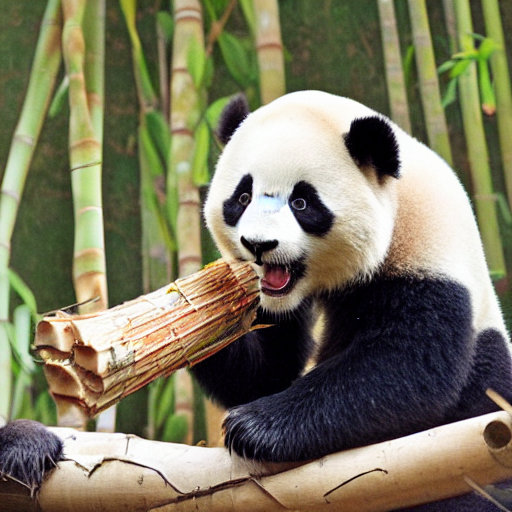

In [42]:
# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# To the GPU
unet = unet.to(torch_device);

# Some settings
prompt = ["A pandas is eating a red colored bamboo"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 25           # Number of denoising steps
guidance_scale = 5                # Scale for classifier-free guidance
generator = torch.manual_seed(13)   # Seed generator to create the inital latent noise
batch_size = 1

unconditional_prompt = ""

# Prep text

###############################################################################
# Complete the Code:
# generate uncond_embeddings and text_embeddings by tokenizer and text_encoder
##############################################################################
# Conditional prompt
text_input = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)

# Unconditional prompt ("")
uncond_input = tokenizer(
    [unconditional_prompt],
    padding="max_length",
    max_length=tokenizer.model_max_length,
    return_tensors="pt",
)

with torch.no_grad():
    text_embeddings = text_encoder(
        text_input.input_ids.to(torch_device)
    )[0]
    uncond_embeddings = text_encoder(
        uncond_input.input_ids.to(torch_device)
    )[0]

##############################################################################

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)
scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):

        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]

        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        ###############################################################################
        # Complete the Code:
        # you need to:
        # 1. predict noise_pred from unet().sample
        # 2. compute CFG by linearly combining the noise_pred_uncond and noise_pred_text
        # 3. use scheduler.step().prev_sample to do the denoising sampling, checkout the manual of scheduler.step()
        ##############################################################################

        # predict noise
        with torch.no_grad():
            noise_pred = unet(
                latent_model_input,
                t,
                encoder_hidden_states=text_embeddings
            ).sample

        #Classifier free guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (
            noise_pred_text - noise_pred_uncond
        )

        # denoising step
        latents = scheduler.step(
            noise_pred,
            t,
            latents
        ).prev_sample

        ################################################################################


# decode the latent to image
decoded = latents_to_pil(latents)[0]
decoded


# Task 4:
Fill in the code for the diffusion process: implement classifier-free guidance (CFG) and denoising sampling.
Try different values for guidance scale, random seeds, samplers, prompts, and the number of sampling steps.
Use these variations to build an image gallery and experiment to see the effects!

# Question 2:
In your opinion, what parameters most influence image quality in diffusion models?
How can we evaluate the quality of images generated by generative models?

# Answer:

The prompt is of course the most influential parameter (it determines the big idea of the generated picture). After this, I would say the order is:
- guidance scale as it balances the result between fidelity and diversity. Typically I got my favorite results with guidance between 4 and 6
- then comes the number of steps: too little will cause some noise to remain in the final image, and too much doesn't increas e the quality (I couldn't find issues with increasing the number of steps, it just adds computaion time)
- then comes the seed, it changes a lot the image but randomly, with no real control on it. Surprisingly the best results I got come from the initial seed (13) although i tried many other ones


Unfortunately the model doesn't like my last prompt, as it struggle to color the bamboo in red :(

# Task 5: Dynamic (Non-Constant) Guidance Schedulers
In standard CFG (Classifier-Free Guidance), the guidance scale is usually a fixed constant. However, recent research (see https://arxiv.org/html/2404.13040v1) suggests that ng a monotonically increasing guidance scale schedule (where guidance grows through the denoising steps) can improve output quality and diversity.
Your task:
- Implement a dynamic CFG schedule (e.g., linearly increasing guidance scale from low to high across diffusion steps).
- Feel free to wrap your logic in a function for clarity and reusability.
- Experiment with several prompts of your choice (such as "flowers in a red vase") and compare results to constant CFG scale.
- (Optional) Try other schedules (e.g., + clamp, cosine) and visualize the difference if you wish.


/tmp/ipython-input-4091371666.py:60: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

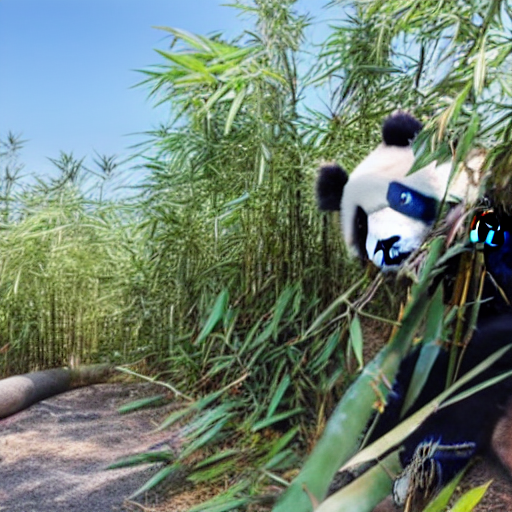

In [24]:

###############################################################################
# Complete the Code:
# Copy paste your previous CFG code/or make a function then call it
# Implement here the dynamic CFG scheduler e.g., Linear one.
# Consider define it as a function to call:
# guidance_scale = guidance_scheduler[int(t)] # t is the timestep
##############################################################################
def linear_guidance_scheduler(step, num_steps, g_min=1.0, g_max=7.5):
    """
    Linearly increases guidance from g_min to g_max.
    """
    return g_min + (g_max - g_min) * (step / (num_steps - 1))


import math

def cosine_guidance_scheduler(step, num_steps, g_min=1.0, g_max=7.5):
    alpha = step / (num_steps - 1)
    return g_min + (g_max - g_min) * (1 - math.cos(math.pi * alpha)) / 2

def sample_with_dynamic_cfg(
    unet,
    scheduler,
    latents,
    text_embeddings,
    num_steps,
    guidance_fn,
):
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps), total=num_steps):

            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            with torch.no_grad():
                noise_pred = unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=text_embeddings
                ).sample

            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            guidance_scale = guidance_fn(i, num_steps)

            noise_pred = noise_pred_uncond + guidance_scale * (
                noise_pred_text - noise_pred_uncond
            )

            latents = scheduler.step(
                noise_pred,
                t,
                latents
            ).prev_sample

    return latents

scheduler.set_timesteps(num_inference_steps)

latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
).to(torch_device)

latents = latents * scheduler.init_noise_sigma

latents = sample_with_dynamic_cfg(
    unet=unet,
    scheduler=scheduler,
    latents=latents,
    text_embeddings=text_embeddings,
    num_steps=num_inference_steps,
    guidance_fn=lambda i, n: cosine_guidance_scheduler(i, n, 1.0, 7.5),
)

decoded = latents_to_pil(latents)[0]
decoded


##############################################################################


The cosine performs quite well, with not much artifacts, at laest better than the linear guidnace that gave me a large artifact around the head of the panda, many times in a row.